# Identificador de doenças em folhas de milho

In [3]:
import os
import cv2

# remove imagens que não conseguimos ler
def remove_bad_images(data):
    for root, dirs, files in os.walk('data'):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = cv2.imread(file_path)
                if img is None:
                    os.remove(file_path)
            except Exception as e:
                os.remove(file_path)


In [4]:
import os
import tensorflow as tf

data_dir = 'data'
encoding = 'latin-1'  # or another encoding that supports the characters in your directory/filenames
file_names = os.listdir(data_dir.encode(encoding))
file_paths = [os.path.join(data_dir, name.decode(encoding)) for name in file_names]

# create a dataset using the file paths
dataset = tf.data.Dataset.from_tensor_slices(file_paths)


In [5]:
import tensorflow as tf

# Carregando as imagens
data_dir = 'data'
batch_size = 32
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 4184 files belonging to 2 classes.
Using 3348 files for training.
Found 4184 files belonging to 2 classes.
Using 836 files for validation.


In [6]:
from tensorflow.keras import layers

# Normalização dos dados
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [7]:
# Tamanho do conjunto de validação
val_size = int(len(train_ds) * 0.2)

# Separando o conjunto de validação do de treino
train_ds = train_ds.skip(val_size)
val_ds = train_ds.take(val_size)


In [8]:
# Criar o modelo
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [9]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Treinar o modelo
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/5


c:\Users\António Lacerda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


84/84 [==============================] - 113s 1s/step - loss: 0.2892 - accuracy: 0.8860 - val_loss: 0.0551 - val_accuracy: 0.9866
Epoch 2/5
84/84 [==============================] - 110s 1s/step - loss: 0.0294 - accuracy: 0.9910 - val_loss: 0.0352 - val_accuracy: 0.9896
Epoch 3/5
84/84 [==============================] - 108s 1s/step - loss: 0.0280 - accuracy: 0.9907 - val_loss: 0.0112 - val_accuracy: 0.9970
Epoch 4/5
84/84 [==============================] - 114s 1s/step - loss: 0.0095 - accuracy: 0.9978 - val_loss: 0.0037 - val_accuracy: 0.9985
Epoch 5/5
84/84 [==============================] - 113s 1s/step - loss: 0.0440 - accuracy: 0.9862 - val_loss: 0.0525 - val_accuracy: 0.9940


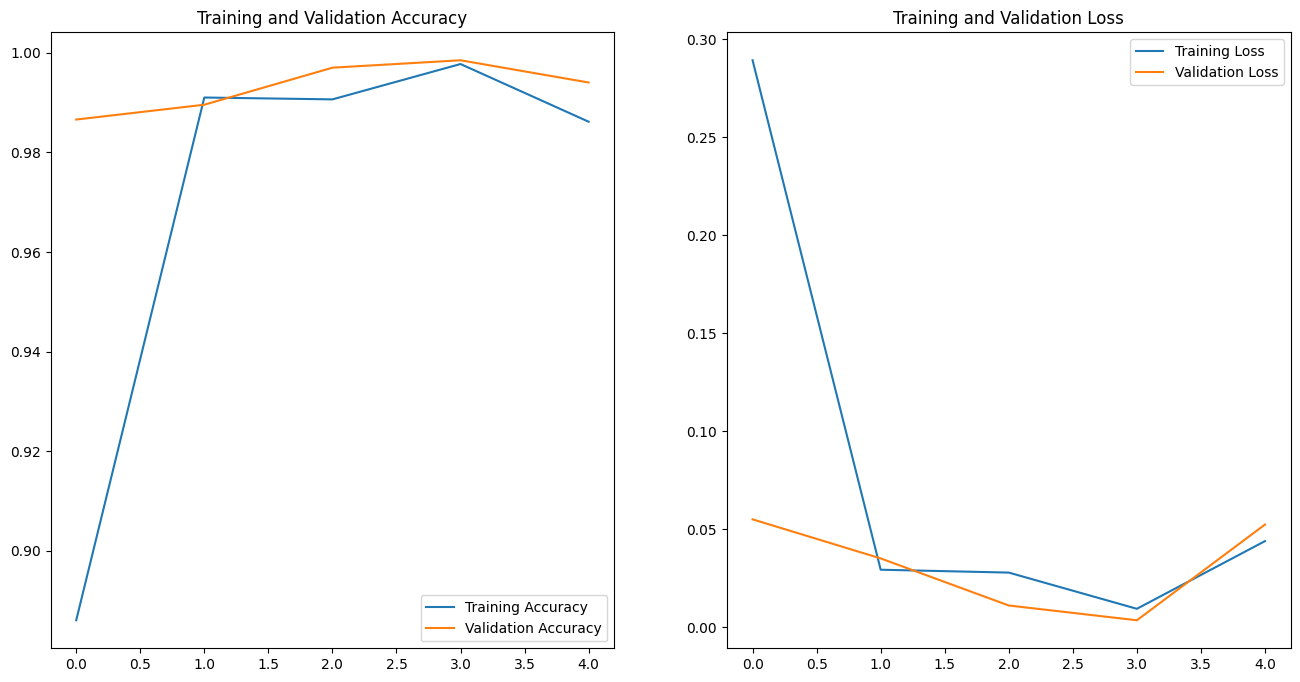

In [10]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [23]:
model.save('milho_h5')


INFO:tensorflow:Assets written to: milho_h5\assets


INFO:tensorflow:Assets written to: milho_h5\assets


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_iterator = test_datagen.flow_from_directory(
        'data',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False)



Found 4184 images belonging to 2 classes.


In [14]:


# Avaliar o modelo nos dados de teste
test_loss, test_acc = model.evaluate(test_iterator)

# Imprimir a precisão no conjunto de testes
print('Test accuracy:', test_acc)


c:\Users\António Lacerda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


131/131 [==============================] - 50s 381ms/step - loss: 0.0549 - accuracy: 0.9914
Test accuracy: 0.9913957715034485


In [24]:
# Importar bibliotecas necessárias
from sklearn.metrics import confusion_matrix

# Obter as predições do modelo para o conjunto de teste
y_pred = milho_h5.predict(data_dir)  # Substitua "modelo" e "X_teste" pelos seus próprios valores

# Comparar com os rótulos verdadeiros do conjunto de teste
cm = confusion_matrix(data_dir, y_pred)  # Substitua "y_teste" pelos rótulos verdadeiros do conjunto de teste

# Plot da matriz de confusão
plot_confusion_matrix(cm, class_names)  # Substitua "class_names" pelos nomes das classes relevantes para o seu modelo

# Exibir o gráfico
plt.show()


NameError: name 'milho_h5' is not defined

In [ ]:
nomes = milho.h5.classes_

NameError: name 'milho' is not defined